# Convert Starlight spectra in file h5

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2023/11/18
- last update : 2023/11/18
- FORS2 : https://github.com/ericnuss/fors2
- Result of StarLight : /sps/lsst/groups/photoz/fors2/FORS2/ResStarlight



          /Users/dagoret/MacOSX/GitHub/LSST/FORS2>ls -l
              total 0
              drwxrwsr-x  3 dagoret  staff   96 Aug 21  2018 ResStarlight
              drwxr-xr-x  9 dagoret  staff  288 Dec 19 18:01 fors2
              
              
- MUST RUN *ExploreFors2_short.ipynb* before

## Import

In [1]:
import os,sys,re
import h5py
from astropy.table import Table
import random

In [2]:
# Import some generally useful packages

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
import pandas as pd
from itertools import cycle, islice


In [3]:
from scipy import ndimage

#from scipy import interp as scinterp
from scipy.interpolate import interp1d

import glob
import collections
#from def_raw_seds import *

In [4]:
# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [5]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [6]:
from def_raw_seds import *

In [7]:
from raw_data_analysis import *

In [8]:
WL_BALMER_BREAK= 3646.0 
NQUANTILES = 10
quantiles = np.linspace(0,1,NQUANTILES+1)
quantiles

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

## Start

In [9]:
cwd=os.path.abspath("")
main_dir = cwd
print(f"notebook current executing path : {cwd}")

notebook current executing path : /Users/dagoret/MacOSX/GitHub/LSST/PhotoZ/PhotoZ_PhD/StudyFors2SED


## Configuration

### SL

## Start

### Catalog

In [10]:
t = Table.read(filename_fits_catalog)

/Users/dagoret/anaconda3/lib/python3.11/site-packages/astropy/io/fits/connect.py:271: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = data[col.name] == col.null


In [11]:
t

ID,m_ID,RAJ2000,DEJ2000,z,u_z,Rmag,RV,e_RV,RT,Nsp,Lines
,,deg,deg,,,mag,km / s,km / s,,,
int16,bytes1,float64,float64,float64,bytes1,float64,int32,int16,float64,int16,bytes77
1,,13.52815,-28.40486,0.55409,,20.79,166227,55,10.0,1,"[OII],H8,K,H"
2,,13.52997,-28.44776,0.34555,,21.18,103665,40,12.3,1,"K,H,G,H{beta}"
3,,13.52552,-28.4208,0.6866,,21.45,210642,48,11.6,4,"[OII],H9,K,H,H{beta},[OIII],H8"
4,,13.52216,-28.40914,0.68653,,21.62,205959,123,10.6,1,"[OII],H9,K,H,G,H{beta}"
7,,13.50974,-28.42972,0.32371,,22.34,97111,11,16.7,6,"[OII],H{beta},[OIII],H{alpha}"
9,,13.50219,-28.40641,0.29266,,21.6,87798,58,13.1,1,"H9,H8,K,H"
...,...,...,...,...,...,...,...,...,...,...,...
738,,13.6437,-28.22527,0.56044,,19.73,168132,126,7.1,1,"K,H,4000{AA}-break,G"


### List

In [12]:
lst=fors2_jct_SL() #remet les spectres dans le rest frame (ie a z=0)

In [13]:
lst = sorted(lst)
print(lst)

['SPEC102', 'SPEC106', 'SPEC107', 'SPEC109', 'SPEC110', 'SPEC111', 'SPEC112', 'SPEC113', 'SPEC114', 'SPEC115', 'SPEC117', 'SPEC118', 'SPEC120', 'SPEC121', 'SPEC123', 'SPEC127', 'SPEC128', 'SPEC13', 'SPEC132', 'SPEC134', 'SPEC135', 'SPEC137', 'SPEC138', 'SPEC141', 'SPEC149', 'SPEC151', 'SPEC152', 'SPEC156', 'SPEC160', 'SPEC161', 'SPEC164', 'SPEC171', 'SPEC178', 'SPEC179', 'SPEC181', 'SPEC182', 'SPEC183', 'SPEC184', 'SPEC185', 'SPEC186', 'SPEC187', 'SPEC188', 'SPEC189', 'SPEC19', 'SPEC191', 'SPEC192', 'SPEC193', 'SPEC194', 'SPEC196', 'SPEC197', 'SPEC198', 'SPEC2', 'SPEC204', 'SPEC205', 'SPEC210', 'SPEC214', 'SPEC218', 'SPEC221', 'SPEC222', 'SPEC223', 'SPEC226', 'SPEC227', 'SPEC231', 'SPEC233', 'SPEC234', 'SPEC235', 'SPEC236', 'SPEC237', 'SPEC238', 'SPEC24', 'SPEC240', 'SPEC242', 'SPEC243', 'SPEC244', 'SPEC245', 'SPEC246', 'SPEC248', 'SPEC249', 'SPEC25', 'SPEC250', 'SPEC252', 'SPEC253', 'SPEC258', 'SPEC259', 'SPEC260', 'SPEC261', 'SPEC262', 'SPEC264', 'SPEC265', 'SPEC266', 'SPEC267', 'SPE

In [14]:
all_specfilenames = os.listdir(path_BC)

In [15]:
all_specfilenames = sorted(all_specfilenames)

In [16]:
all_numbers = [ int(re.findall('^SPEC(.*)_HZ4_BC[.]txt$',fn)[0]) for fn in all_specfilenames ]

In [17]:
all_numbers = sorted(all_numbers)

In [18]:
NSED = len(all_numbers)
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NSED)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSED), alpha=1)

In [19]:
cut = t["ID"] == 3
t[cut]

ID,m_ID,RAJ2000,DEJ2000,z,u_z,Rmag,RV,e_RV,RT,Nsp,Lines
,,deg,deg,,,mag,km / s,km / s,,,
int16,bytes1,float64,float64,float64,bytes1,float64,int32,int16,float64,int16,bytes77
3,,13.52552,-28.4208,0.6866,,21.45,210642,48,11.6,4,"[OII],H9,K,H,H{beta},[OIII],H8"


# Read all SEDS and noremalised 

In [20]:
NSAMPLES = NSED

In [21]:
all_normspectra = []
all_integ = []
all_tag = []
all_sed = []
all_wl = []

all_redshifts = []
all_num = []
all_ra = []
all_dec = []
all_Rmag = []
all_RV = []
all_eRV = []
all_RT = []
all_Nsp = []


for idx,the_num in enumerate(all_numbers):
    
    tcut     = t["ID"] == the_num
    redshift = t[tcut]["z"].value[0]
    lines    = t[tcut]["Lines"].value[0]
    ra       = t[tcut]["RAJ2000"].value[0]
    dec      = t[tcut]["DEJ2000"].value[0]
    Rmag     = t[tcut]["Rmag"].value[0]
    RV       = t[tcut]["RV"].value[0]
    e_RV     = t[tcut]["e_RV"].value[0]
    RT       = t[tcut]["RT"].value[0]
    Nsp      = t[tcut]["Nsp"].value[0]
    
    
    
    
    filename = f"SPEC{the_num}_HZ4_BC.txt"
    tag = f"SPEC{the_num} , z={redshift:.2f}, lines={lines}"
    fullfilename = os.path.join(path_BC,filename)
    the_sed=SED(fullfilename,label=tag)
    all_sed.append(the_sed)
    arr = np.loadtxt(fullfilename)
    
    # select wavelength in an appropriate range 
    #wl=arr[:-1,0]  
    #wlrange = np.where(np.logical_and(wl>=0,wl<=10000))[0]
    
    wl=arr[:,0] 
    flambda=arr[:,1]
    
    x = wl
    y = flambda
    
    # normalize spectrum wrt its integral between 0-10000 angstrom
    integ = np.trapz(y,x)
    the_normspectra = y/integ

    all_normspectra.append(the_normspectra)
    all_sed.append(flambda)
    all_wl.append(wl)
    
    all_tag.append(tag)
    
    # RAJ2000	DEJ2000	z	u_z	Rmag	RV	e_RV	RT	Nsp	
    all_redshifts.append(redshift)
    all_num.append(the_num) 
    all_ra.append(ra) 
    all_dec.append(dec) 
    all_Rmag.append(Rmag)
    all_RV.append(RV)
    all_eRV.append(e_RV)
    all_RT.append(RT)
    all_Nsp.append(Nsp)
    

In [22]:
all_redshifts = np.array(all_redshifts)
all_num = np.array(all_num)
all_ra = np.array(all_ra)
all_dec = np.array(all_dec)
all_Rmag = np.array(all_Rmag)
all_RV = np.array(all_RV)
all_eRV = np.array(all_eRV)
all_RT = np.array(all_RT)
all_Nsp = np.array(all_Nsp)

In [23]:
NQUANTILES = 10
cmap = plt.cm.get_cmap('jet', NQUANTILES) 
quantiles = np.linspace(0,1,NQUANTILES+1)
quantiles

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_52091/691879846.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', NQUANTILES)


array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [24]:
quantiles_thr = np.quantile(all_redshifts, quantiles)
digitized = np.digitize(all_redshifts,quantiles_thr)

In [25]:
#digitized

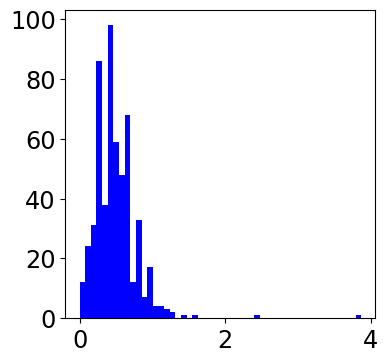

In [26]:
plt.hist(all_redshifts,bins=50,facecolor="blue");

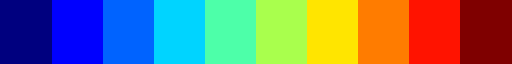

In [27]:
cmap

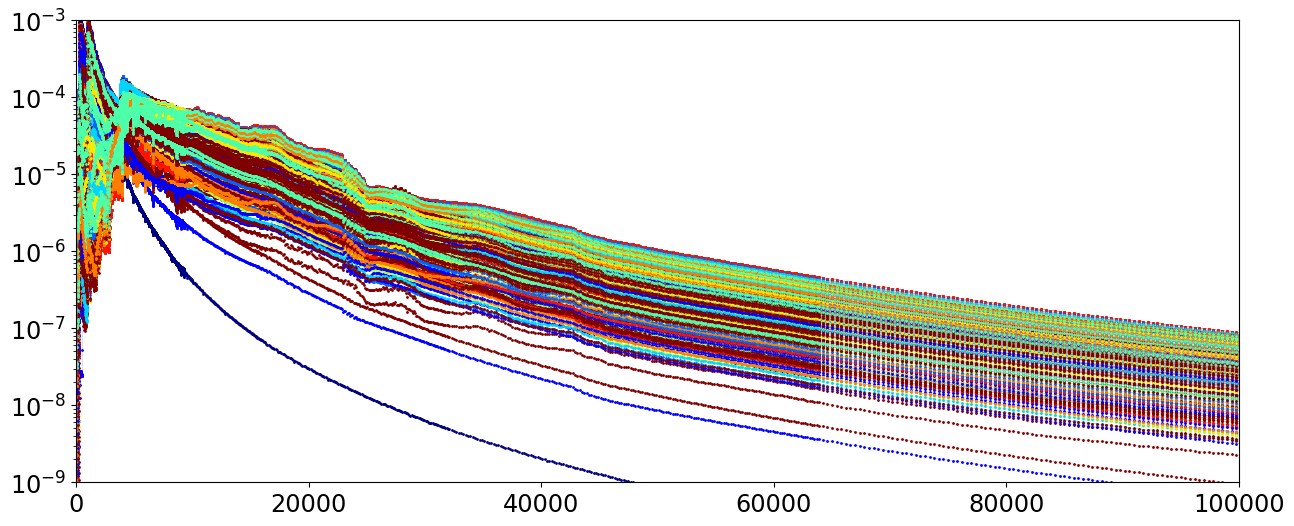

In [28]:
fig, ax = plt.subplots(1,1,figsize=(15,6))
for index in range(NSED):
    nq = digitized[index]-1
    col =cmap(NQUANTILES-nq)
    ax.plot(all_wl[index],all_normspectra[index],'o-',color=col,ms=1.,lw=0.1)
ax.set_xlim(0,100000)
ax.set_ylim(1e-9,1e-3)
ax.set_yscale('log')

# Save in a file 

In [29]:
output_file_h5  = 'SLspectra_manyPoints.hdf5'
hf_outfile =  h5py.File(output_file_h5, 'w') 

In [30]:
for idx,the_num in enumerate(all_numbers):
    tag = f"SPEC{the_num}"
    h5group = hf_outfile.create_group(tag)
    
    h5group.attrs['num'] = the_num
    h5group.attrs['redshift'] = all_redshifts[idx]
   
    h5group.attrs["ra"] = all_ra[idx] 
    h5group.attrs["dec"] = all_dec[idx]
    h5group.attrs["Rmag"] = all_Rmag[idx]
    h5group.attrs["RV"] = all_RV[idx]
    h5group.attrs["eRV"] = all_eRV[idx]
    h5group.attrs["RT"] = all_RT[idx]
    h5group.attrs["Nsp"] = all_Nsp[idx]
    
    d = h5group.create_dataset("wl",data=all_wl[index],compression="gzip", compression_opts=9)
    d = h5group.create_dataset("fl",data=all_normspectra[idx],compression="gzip", compression_opts=9)

In [31]:
hf_outfile.keys()

<KeysViewHDF5 ['SPEC102', 'SPEC106', 'SPEC107', 'SPEC109', 'SPEC110', 'SPEC111', 'SPEC112', 'SPEC113', 'SPEC114', 'SPEC115', 'SPEC117', 'SPEC118', 'SPEC120', 'SPEC121', 'SPEC123', 'SPEC127', 'SPEC128', 'SPEC13', 'SPEC132', 'SPEC134', 'SPEC135', 'SPEC137', 'SPEC138', 'SPEC141', 'SPEC149', 'SPEC151', 'SPEC152', 'SPEC156', 'SPEC160', 'SPEC161', 'SPEC164', 'SPEC171', 'SPEC178', 'SPEC179', 'SPEC181', 'SPEC182', 'SPEC183', 'SPEC184', 'SPEC185', 'SPEC186', 'SPEC187', 'SPEC188', 'SPEC189', 'SPEC19', 'SPEC191', 'SPEC192', 'SPEC193', 'SPEC194', 'SPEC196', 'SPEC197', 'SPEC198', 'SPEC2', 'SPEC204', 'SPEC205', 'SPEC210', 'SPEC214', 'SPEC218', 'SPEC221', 'SPEC222', 'SPEC223', 'SPEC226', 'SPEC227', 'SPEC231', 'SPEC233', 'SPEC234', 'SPEC235', 'SPEC236', 'SPEC237', 'SPEC238', 'SPEC24', 'SPEC240', 'SPEC242', 'SPEC243', 'SPEC244', 'SPEC245', 'SPEC246', 'SPEC248', 'SPEC249', 'SPEC25', 'SPEC250', 'SPEC252', 'SPEC253', 'SPEC258', 'SPEC259', 'SPEC260', 'SPEC261', 'SPEC262', 'SPEC264', 'SPEC265', 'SPEC266', '

In [32]:
hf_outfile.close() 

In [34]:
assert False

AssertionError: 

# Read again the data

In [ ]:
with h5py.File('SLspectra.hdf5', 'r') as hf:
    data_in = hf['flambda'][:]
    wl_in = hf['wl'][:]
    target = hf['quantile'][:]

    # other data
    redshift = hf['redshift'][:]
    Rmag = hf['Rmag'][:]
    RT = hf['RT'][:]
    RV = hf['RV'][:]
    ra = hf['ra'][:]
    dec = hf['dec'][:]
    fracinfbalmer = hf['fracinfbalmer'][:]


In [ ]:
spectra = data_in
wavelengths = wl_in

In [ ]:
spectra.shape

In [ ]:
#plt.figure(figsize=(16,20))
if 0:
    for idx in range(NSED):
        plt.figure(figsize=(16,2))
        #plt.plot(all_wl[idx],all_normspectra[idx], color=all_colors[idx],label=all_tag[idx])
        plt.plot(wl_in,data_in[idx,:], color=all_colors[idx],label=all_tag[idx])
        plt.legend(loc="upper right")
        plt.grid()
        #plt.axvline(4150,color="k")
        #plt.axvline(4250,color="k")
        #plt.ylim(-0.02,0.4)
        #plt.xlim(0.,20000.)
    plt.show()

In [ ]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(1-fracinfbalmer, alpha=1)

In [ ]:
fig = plt.figure(figsize=(5,4))
ax=fig.add_subplot(1,1,1)
ax.scatter(fracinfbalmer,target,color=all_colors,cmap=jet)
ax.set_xlabel("fracinfbalmer")
ax.set_ylabel("quantile number (target)")
ax.grid()

In [ ]:
NQ = len(np.unique(target))

In [ ]:
jet10 = plt.get_cmap('jet')
cNorm10 = colors.Normalize(vmin=1, vmax=NQ)
scalarMap10 = cmx.ScalarMappable(norm=cNorm10, cmap=jet10)
all_colors10 = scalarMap10.to_rgba(np.arange(10,0,-1), alpha=1)

In [ ]:
ncols=2
nrows= NQ//ncols

In [ ]:
nrows

In [ ]:
fig, axes = plt.subplots(ncols=ncols,nrows=nrows, sharex=True, sharey=False,figsize=(10,12))

# loop on quantiles
for idx, ax in enumerate(axes.flat):
    
    selected_indexes = np.where(target==idx+1)[0]
            
    for idx_sel in selected_indexes:
        u = random.random()
        if u< 0.07:
            ax.plot(wavelengths,spectra[idx_sel,:],c=all_colors10[idx] )
    ax.set_xlim(0,10000) 
    
    if idx==8 or idx ==9:
        ax.set_xlabel("$\lambda  (\AA)$")
        
    if idx%ncols ==0:
        ax.set_ylabel("flux $F_\lambda$")
        
plt.tight_layout()